In [6]:
# filter warnings for presentation's sake
import warnings
warnings.filterwarnings('ignore')

# general packages
import sys
from time import time
from collections import defaultdict, OrderedDict
import sqlite3

import daft
from ipywidgets import interactive, fixed

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import patsy as pt
from scipy import optimize, stats
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import statsmodels.api as sm
import arviz as az

# pymc3 libraries
import pymc3 as pm
import theano as thno
import theano.tensor as T
import stan

# filter warnings for presentation's sake
import warnings
warnings.filterwarnings('ignore')

import os
import pickle
import string
import regex as re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KernelDensity
import pymc3 as pm
import nest_asyncio
nest_asyncio.apply()

In [7]:
def bic(obs, pred, p):
    rss = np.sum(np.square(obs-pred))
    n = len(obs)
    return p*np.log(n)+n*np.log(rss/n)

In [8]:
odor = pd.read_csv('womendaily+rating.csv')

odor1 = odor[odor['water'].isna()].dropna(subset=['raterid'])
odor2 = odor1[["SubId.0", "raterid", "Salivanumb", "Estradiol.ext", "Progest", 
               "Pleasant","Intensity","Sexiness"]]

#calculate rater centered ratings
means = odor2.groupby('raterid')['Pleasant','Sexiness','Intensity', 'raterid'].mean()
means.columns = ['Pleasant_mean','Sexiness_mean','Intensity_mean', 'raterid']

odor3 = odor2.set_index('raterid').join(means.set_index('raterid')).reset_index()
odor3["Pleasant_ratcen"] = odor3["Pleasant"]-odor3["Pleasant_mean"]
odor3["Intensity_ratcen"] = odor3["Intensity"]-odor3["Intensity_mean"]
odor3["Sexiness_ratcen"] = odor3["Sexiness"]-odor3["Sexiness_mean"]

#calculate donor centered hormones with SD of the all donors
means2 = odor2.groupby('SubId.0')['Estradiol.ext', 'Progest','SubId.0'].mean()
means2.columns = ['E_submean', 'P_submean','SubId.0']

odor4 = odor3.set_index('SubId.0').join(means2.set_index('SubId.0')).reset_index()
odor4['subcenzestrad'] = (odor4['Estradiol.ext']-odor4['E_submean'])/odor['Estradiol.ext'].std()
odor4['subcenzprogest'] = (odor4['Progest']-odor4['P_submean'])/odor['Progest'].std()
odor4['sexyplea_ratcen'] = (odor3["Pleasant_ratcen"] + odor3["Sexiness_ratcen"])/2

odordf = odor4[["SubId.0", "raterid", "Salivanumb", "subcenzestrad", "subcenzprogest", 
               "Pleasant_ratcen","Intensity_ratcen","Sexiness_ratcen","sexyplea_ratcen"]]
odormean = odordf.groupby(['SubId.0', 'Salivanumb']).mean().dropna(subset=['subcenzestrad','subcenzprogest'])
odormean = odormean.reset_index()
p = len(odormean.columns.tolist())
names = odormean.columns.tolist()
odormean.columns = ['subid', 'salivanum']+[x for x in names[2:p]]
le = LabelEncoder()

In [9]:
odormean.describe()

,subid,salivanum,raterid,subcenzestrad,subcenzprogest,Pleasant_ratcen,Intensity_ratcen,Sexiness_ratcen,sexyplea_ratcen
count,271.000000,271.000000,271.000000,2.710000e+02,2.710000e+02,271.000000,271.000000,271.000000,271.000000
mean,128.022140,3.479705,1033.569396,-2.288043e-16,3.932893e-17,-0.002080,-0.001278,-0.000043,-0.000291
std,15.509121,1.714468,21.051409,7.437462e-01,7.799657e-01,0.630310,0.698381,0.518371,0.294675
min,101.000000,1.000000,1005.500000,-2.364934e+00,-2.515070e+00,-1.476790,-1.624060,-1.088972,-1.019231
25%,115.000000,2.000000,1017.083333,-3.590621e-01,-4.617630e-01,-0.402548,-0.501603,-0.354154,-0.196853
50%,130.000000,3.000000,1030.500000,-9.026849e-02,-1.299592e-01,-0.043269,-0.040716,-0.051282,0.000962
75%,141.000000,5.000000,1046.923077,3.134105e-01,2.565687e-01,0.327068,0.415064,0.302222,0.188838
max,153.000000,6.000000,1065.294118,6.117235e+00,4.393894e+00,2.623397,2.081731,1.865385,0.873873


In [10]:
odormean['donor_enc'] = le.fit_transform(odormean['subid'])
ft_endog = 'sexyplea_ratcen'
fml_part_pooled = '{} ~ '.format(ft_endog) + ' + '.join(['subcenzestrad', 'subcenzprogest'])
print(fml_part_pooled)
n_donor = odormean['donor_enc'].max()+1

(mx_en, mx_ex) = pt.dmatrices(fml_part_pooled, odormean, return_type='dataframe', NA_action='raise')
mx_ex = mx_ex[['subcenzestrad', 'subcenzprogest']]

mdl_part_pooled_stan_dict = {}
mdl_part_pooled_stan_dict['N'] = mx_ex.shape[0]
mdl_part_pooled_stan_dict['K'] = mx_ex.shape[1]
mdl_part_pooled_stan_dict['X'] = mx_ex.values
mdl_part_pooled_stan_dict['y'] = mx_en[ft_endog].values

mdl_part_pooled_stan_dict['donor_enc'] = odormean['donor_enc'].values + 1
mdl_part_pooled_stan_dict['n_donor'] = n_donor

mdl_part_pooled_stan_spec ="""
    data {
        int<lower=0> N;
        int<lower=0> K;
        matrix[N, K] X;
        vector[N] y;
        int<lower=0> n_donor;
        int<lower = 1, upper=n_donor> donor_enc[N];
    }
    parameters {
        vector[K] beta;
        real<lower=0> sigma;
        
        real donor_mu;
        real<lower=0> donor_sd;
        vector[n_donor] b0_donor;
    }
    model{
        beta ~normal(0,10);
        donor_mu ~normal(0,10);
        donor_sd ~inv_chi_square(2);

        for(donor in 1:n_donor){
            b0_donor[donor]~normal(donor_mu, donor_sd);
        }

        sigma ~ inv_chi_square(2);
        y~normal(b0_donor[donor_enc]+X*beta, sigma);
    }
    generated quantities{}
"""

sexyplea_ratcen ~ subcenzestrad + subcenzprogest


In [11]:
mdl_part_pooled_stan_fit = stan.build(mdl_part_pooled_stan_spec, data=mdl_part_pooled_stan_dict)
fit = mdl_part_pooled_stan_fit.hmc_nuts_diag_e_adapt(num_chains=4, num_samples=1000, num_warmup=500,num_thin=1)

df = fit.to_frame()

Building...



Building: found in cache, done.Sampling:   0%
Sampling:   7% (400/6000)
Sampling:  32% (1900/6000)
Sampling:  57% (3400/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.000306 seconds
  1000 transitions using 10 leapfrog steps per transition would take 3.06 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_r0_ia_fz/model_gx5uhyyj.stan', line 28, column 8 to column 52)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
  Gradient evaluation took 0.000332 seconds
  1

In [12]:
df.describe()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,beta.2,sigma,...,b0_donor.37,b0_donor.38,b0_donor.39,b0_donor.40,b0_donor.41,b0_donor.42,b0_donor.43,b0_donor.44,b0_donor.45,b0_donor.46
count,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,293.215441,0.880695,0.339011,3.84750,14.336000,0.0,-267.480851,0.033666,-0.032164,0.296721,...,0.058109,-0.028813,0.003889,-0.001355,-0.015053,0.023786,0.003277,-0.008899,-0.000640,0.002234
std,9.278537,0.130149,0.017052,0.35955,3.010875,0.0,10.540490,0.026618,0.026112,0.012891,...,0.066346,0.063189,0.063073,0.061151,0.064851,0.064226,0.062499,0.063798,0.064675,0.063646
min,258.764309,0.154184,0.318954,3.00000,7.000000,0.0,-301.603891,-0.067828,-0.135425,0.251485,...,-0.166257,-0.268775,-0.270409,-0.233788,-0.324553,-0.203133,-0.207481,-0.285565,-0.318456,-0.220774
25%,286.949748,0.821953,0.331093,4.00000,15.000000,0.0,-274.767320,0.015516,-0.049477,0.287708,...,0.013016,-0.068763,-0.036021,-0.040596,-0.056038,-0.018013,-0.036216,-0.050394,-0.044830,-0.040863
50%,293.361380,0.927104,0.335480,4.00000,15.000000,0.0,-267.571340,0.033441,-0.031772,0.296314,...,0.054687,-0.026908,0.003144,-0.000716,-0.014258,0.021616,0.002222,-0.009849,-0.001453,0.002567
75%,299.485115,0.977887,0.343397,4.00000,15.000000,0.0,-260.455448,0.051818,-0.014916,0.305262,...,0.100611,0.014238,0.044562,0.040090,0.026873,0.063094,0.043692,0.032295,0.041520,0.044238
max,321.120318,1.000000,0.366128,4.00000,31.000000,0.0,-225.291316,0.141554,0.078517,0.344199,...,0.336298,0.235476,0.279717,0.236165,0.265936,0.270574,0.280654,0.232202,0.232665,0.256494


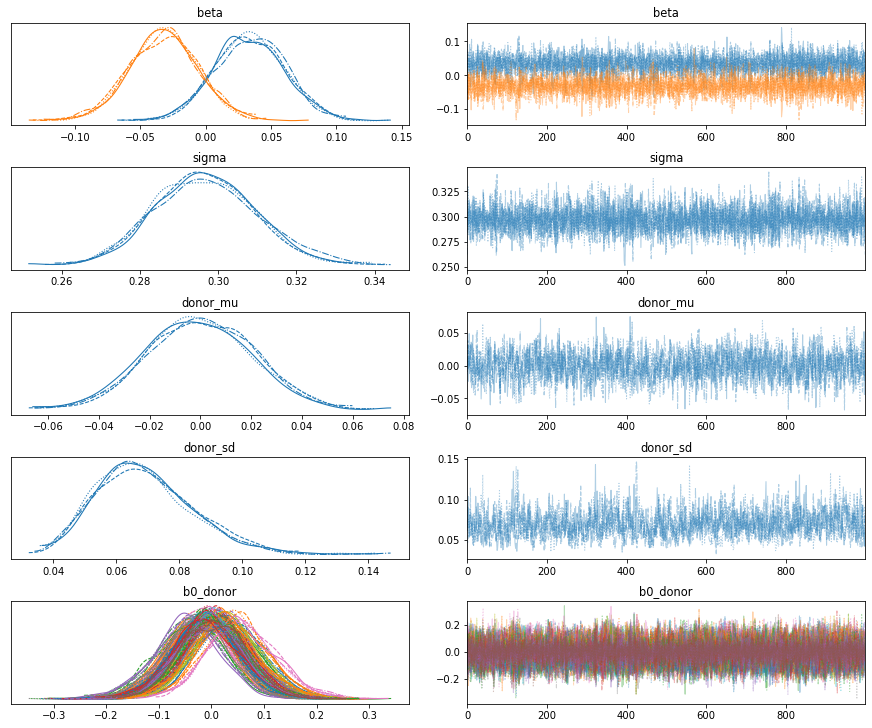

In [13]:
ax = az.plot_trace(fit)

In [14]:
# Seperate parameter columns from trace columns of fit
info_col = df.columns[0:6]
parameter_col = df.columns[7:58]

In [15]:
# x is a matrix containing the observed values of our covariates
x = np.zeros((271,48))
x[:,:2] = odormean[['subcenzestrad', 'subcenzprogest']].to_numpy()
j = 0
for i in odormean['donor_enc']:
    x[j, i+2] = 1
    j += 1

In [16]:
# parms are the parameters from fit that are used to estimate our sexyplea_ratcen observations
parms = [0,1]+[x for x in range(5,51)]
parms = parameter_col.take(parms)

# the first row of est contains 4000 estimates of the first observation of sexyplea_ratcen in odormean
est = x@df[parms].T

In [17]:
# add identifiers to estimate dataframe
est['subid'] = odormean['subid']
est['salivanum'] = odormean['salivanum']
est = est.set_index(['subid', 'salivanum'])

# transform data to longformat for plotting
eplot = pd.melt(est.T)

# calculate an overall estimate by averaging over the 4000 estimates
mean_est = eplot.groupby(['subid', 'salivanum']).agg('mean')

In [18]:
eplot = eplot.set_index(['subid','salivanum']).join(odormean.set_index(['subid', 'salivanum'])['sexyplea_ratcen'], how = 'right').reset_index()

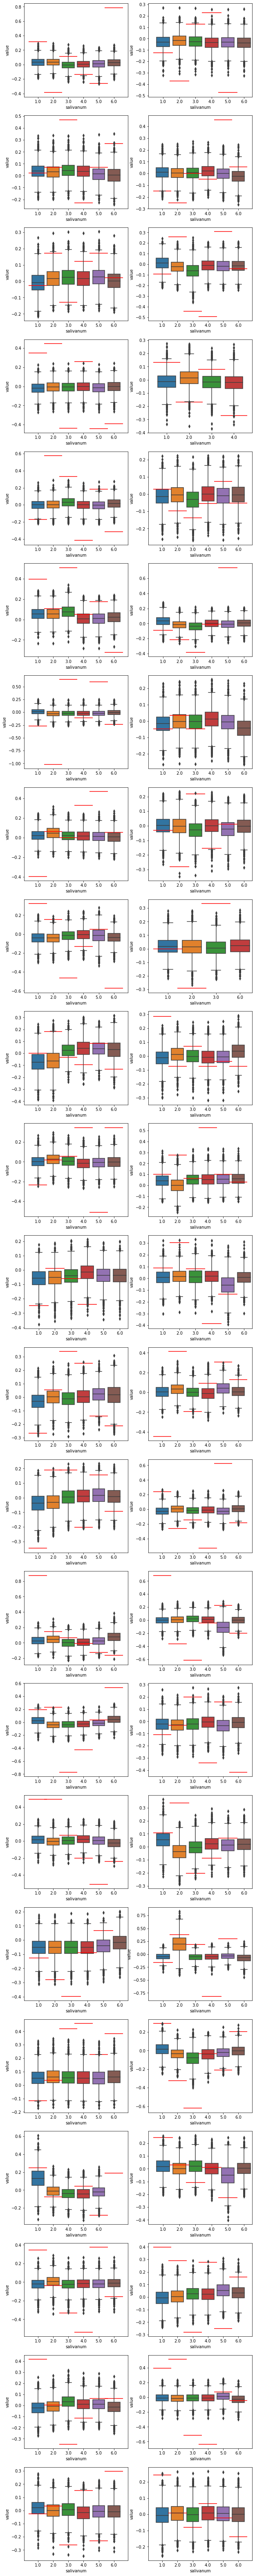

In [19]:
subids = eplot['subid'].unique()
subids = np.array([[x,y] for (x,y) in zip(subids[2*np.arange(23)], subids[2*np.arange(23)+1])])
fig, axe = plt.subplots(23, 2, figsize = (10,115));
for ax, subid in zip(axe, subids):
    for ax, subid in zip(ax, subid):
        dat = eplot.query('subid==@subid');
        xy = [[x,y] for (x,y) in zip(dat['sexyplea_ratcen'].unique(), dat['salivanum'].unique())]
        sns.boxplot(data = dat, x = 'salivanum', y = 'value', ax = ax);
        for i in enumerate(xy):
            ax.hlines(i[1][0], i[1][1]-1.6,i[1][1]-0.4, color = 'red')
plt.show()

In [20]:
mean_est['value']

subid  salivanum
101    1.0          0.031779
       2.0          0.035436
       3.0         -0.005032
       4.0          0.003819
       5.0          0.011098
                      ...   
153    2.0          0.007242
       3.0         -0.000900
       4.0          0.008146
       5.0          0.004409
       6.0         -0.000729
Name: value, Length: 271, dtype: float64

In [21]:
obs = np.array(odormean['sexyplea_ratcen'])
pred = np.array(mean_est['value'])
p = len(parameter_col)
bic_full = bic(obs, pred, p)

In [22]:
odormean['donor_enc'] = le.fit_transform(odormean['subid'])
ft_endog = 'sexyplea_ratcen'
fml_part_pooled = '{} ~ '.format(ft_endog) + ' + '.join(['subcenzestrad'])
print(fml_part_pooled)
n_donor = odormean['donor_enc'].max()+1

(mx_en, mx_ex) = pt.dmatrices(fml_part_pooled, odormean, return_type='dataframe', NA_action='raise')
mx_ex = mx_ex[['subcenzestrad']]

mdl_part_pooled_null_dict = {}
mdl_part_pooled_null_dict['N'] = mx_ex.shape[0]
mdl_part_pooled_null_dict['K'] = mx_ex.shape[1]
mdl_part_pooled_null_dict['X'] = mx_ex.values
mdl_part_pooled_null_dict['y'] = mx_en[ft_endog].values

mdl_part_pooled_null_dict['donor_enc'] = odormean['donor_enc'].values + 1
mdl_part_pooled_null_dict['n_donor'] = n_donor

mdl_part_pooled_null_spec ="""
    data {
        int<lower=0> N;
        int<lower=0> K;
        matrix[N, K] X;
        vector[N] y;
        int<lower=0> n_donor;
        int<lower = 1, upper=n_donor> donor_enc[N];
    }
    parameters {
        vector[K] beta;
        real<lower=0> sigma;
        
        real donor_mu;
        real<lower=0> donor_sd;
        vector[n_donor] b0_donor;
    }
    model{
        donor_mu ~normal(0,10);
        donor_sd ~inv_chi_square(2);

        for(donor in 1:n_donor){
            b0_donor[donor]~normal(donor_mu, donor_sd);
        }

        sigma ~ inv_chi_square(2);
        y~normal(b0_donor[donor_enc]+X*beta, sigma);
    }
    generated quantities{}
"""

sexyplea_ratcen ~ subcenzestrad


In [24]:
mdl_part_pooled_null_fit = stan.build(mdl_part_pooled_null_spec, data=mdl_part_pooled_null_dict)
fit_null = mdl_part_pooled_null_fit.hmc_nuts_diag_e_adapt(num_chains=4, num_samples=1000, num_warmup=500,num_thin=1)

dfnull = fit_null.to_frame()

Building...



Building: 52.8s, done.Messages from stanc:
  The parameter beta has no priors.
Sampling:   0%
Sampling:   7% (400/6000)
Sampling:  32% (1900/6000)
Sampling:  57% (3400/6000)
Sampling:  82% (4900/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.00012 seconds
  1000 transitions using 10 leapfrog steps per transition would take 1.2 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in '/tmp/httpstan_ax8q2wxj/model_jfqs2rxr.stan', line 27, column 8 to column 52)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.
 

In [25]:
dfnull.describe()
dfold = df
df = dfnull

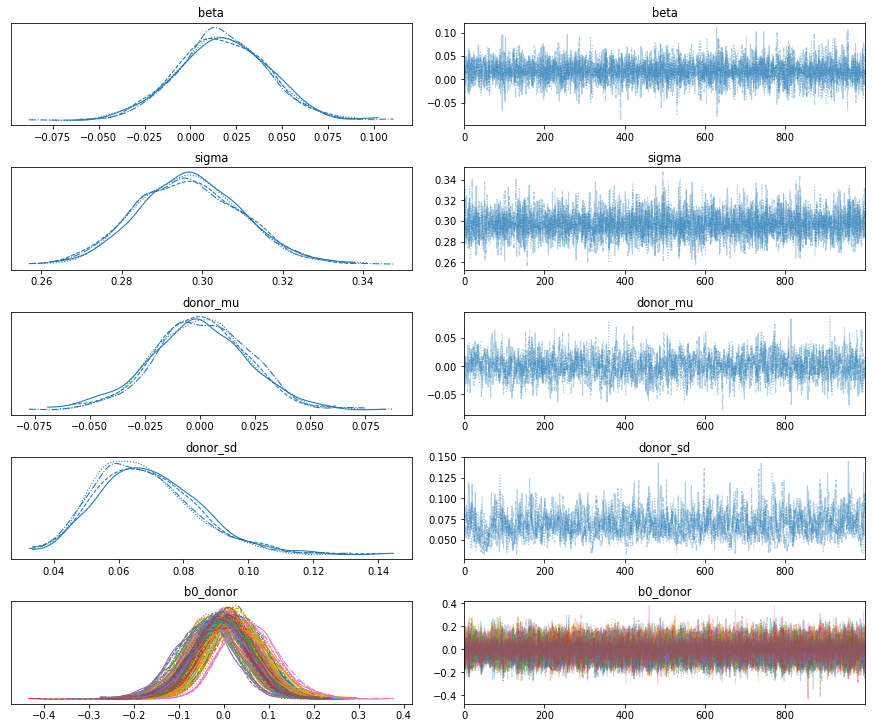

In [26]:
ax = az.plot_trace(fit_null)

In [27]:
df.head()

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,beta.1,sigma,donor_mu,...,b0_donor.37,b0_donor.38,b0_donor.39,b0_donor.40,b0_donor.41,b0_donor.42,b0_donor.43,b0_donor.44,b0_donor.45,b0_donor.46
draws,,,,,,,,,,,,,,,,,,,,,
0,276.282299,1.000000,0.324833,4.0,15.0,0.0,-252.207749,0.046805,0.291423,-0.043774,...,-0.003049,-0.014085,0.057736,-0.057873,0.049226,0.036539,-0.251900,-0.044629,0.023306,-0.056262
1,300.679494,0.994373,0.283071,4.0,15.0,0.0,-274.342864,0.037893,0.277781,-0.012248,...,0.038575,0.016530,-0.038523,-0.022563,0.073057,-0.061492,0.029950,-0.036970,-0.052617,-0.017847
2,293.901015,0.935325,0.316060,4.0,15.0,0.0,-269.858305,-0.002905,0.290035,-0.025913,...,0.026969,-0.009823,0.020720,-0.075006,-0.062262,0.025272,-0.013703,-0.133010,-0.028023,-0.048310
3,285.261504,0.827405,0.334692,4.0,15.0,0.0,-254.993264,0.013233,0.281452,0.063592,...,0.149768,-0.014990,-0.040495,-0.017266,-0.006070,0.092987,0.090606,0.028891,-0.031380,-0.068175
4,272.554340,0.916923,0.324833,4.0,15.0,0.0,-241.768021,0.082225,0.276974,-0.010537,...,0.108716,-0.175811,0.004817,-0.045540,0.029128,0.096593,-0.030359,-0.085785,-0.047104,-0.067674


In [28]:
# Seperate parameter columns from trace columns of fit
info_col = df.columns[0:6]
parameter_col = df.columns[7:57]

In [29]:
# x is a matrix containing the observed values of our covariates
x = np.zeros((271,47))
x[:,:1] = odormean[['subcenzestrad']].to_numpy()
j = 0
for i in odormean['donor_enc']:
    x[j, i+1] = 1
    j += 1

In [30]:
# parms are the parameters from fit that are used to estimate our sexyplea_ratcen observations
parms = [0]+[x for x in range(4,50)]
parms = parameter_col.take(parms)

# the first row of est contains 4000 estimates of the first observation of sexyplea_ratcen in odormean
est = x@df[parms].T

In [31]:
# add identifiers to estimate dataframe
est['subid'] = odormean['subid']
est['salivanum'] = odormean['salivanum']
est = est.set_index(['subid', 'salivanum'])

# transform data to longformat for plotting
eplot = pd.melt(est.T)

# calculate an overall estimate by averaging over the 4000 estimates
mean_est = eplot.groupby(['subid', 'salivanum']).agg('mean')

In [32]:
eplot = eplot.set_index(['subid','salivanum']).join(odormean.set_index(['subid', 'salivanum'])['sexyplea_ratcen'], how = 'right').reset_index()

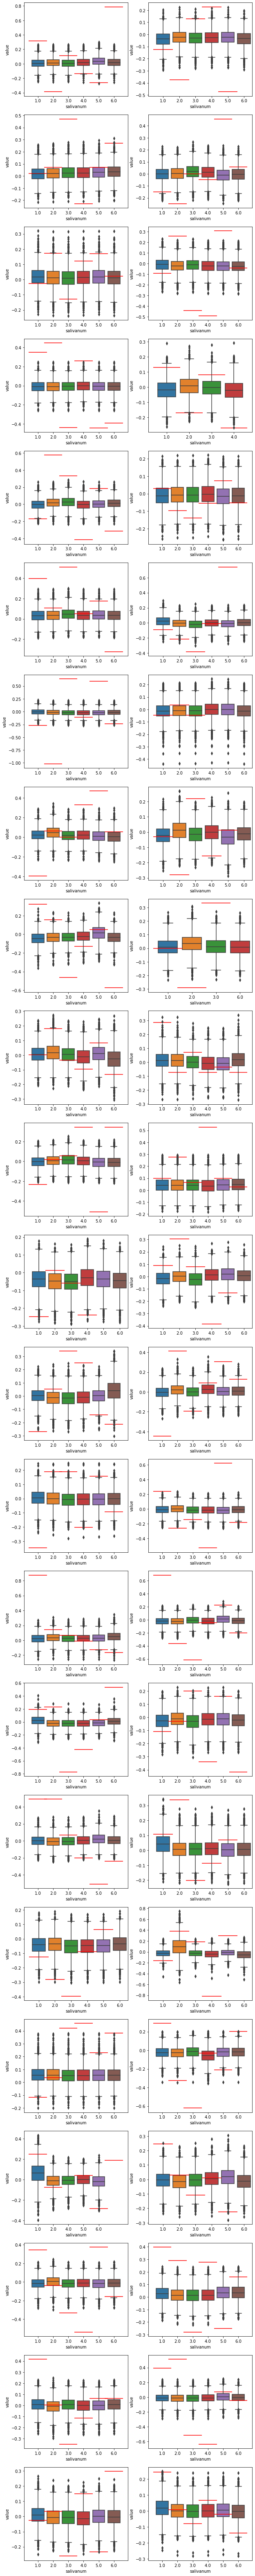

In [33]:
subids = eplot['subid'].unique()
subids = np.array([[x,y] for (x,y) in zip(subids[2*np.arange(23)], subids[2*np.arange(23)+1])])
fig, axe = plt.subplots(23, 2, figsize = (10,115));
for ax, subid in zip(axe, subids):
    for ax, subid in zip(ax, subid):
        dat = eplot.query('subid==@subid');
        xy = [[x,y] for (x,y) in zip(dat['sexyplea_ratcen'].unique(), dat['salivanum'].unique())]
        sns.boxplot(data = dat, x = 'salivanum', y = 'value', ax = ax);
        for i in enumerate(xy):
            ax.hlines(i[1][0], i[1][1]-1.6,i[1][1]-0.4, color = 'red')
plt.show()

In [34]:
mean_est['value']

subid  salivanum
101    1.0          0.007447
       2.0          0.015505
       3.0          0.006775
       4.0          0.018124
       5.0          0.035650
                      ...   
153    2.0          0.001150
       3.0         -0.001378
       4.0          0.001086
       5.0          0.004171
       6.0         -0.002601
Name: value, Length: 271, dtype: float64

In [35]:
obs = np.array(odormean['sexyplea_ratcen'])
pred = np.array(mean_est['value'])
p = len(parameter_col)
bic_null = bic(obs, pred, p)

In [36]:
bic_full-bic_null

3.9751570612511387